In [3]:
import json
import numpy as np
import tensorflow as tf
import tensorflow.python.keras.backend as K

from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives import hashes
from cryptography.hazmat.primitives.asymmetric import ec
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers.aead import AESGCM

from helpers.utils import get_public_key, get_private_key, NumpyEncoder, NumpyDecoder, get_dataset, fetch_index

In [38]:
def encrypt_message(message, recipient_public_key):
    ephemeral_private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
    ephemeral_public_key = ephemeral_private_key.public_key()

    shared_secret = ephemeral_private_key.exchange(ec.ECDH(), recipient_public_key)

    derived_key_material = HKDF(
        algorithm=hashes.SHA256(),
        length=32 + 12,
        salt=None,
        info=b'',
    ).derive(shared_secret)

    encryption_key = derived_key_material[:32]
    nonce = derived_key_material[32:]

    cipher = AESGCM(encryption_key)
    ciphertext = cipher.encrypt(nonce, message.encode(), None)

    return ephemeral_public_key, ciphertext


def decrypt_message(ciphertext, ephemeral_public_key, recipient_private_key):
    shared_secret = recipient_private_key.exchange(ec.ECDH(), ephemeral_public_key)

    derived_key_material = HKDF(
        algorithm=hashes.SHA256(),
        length=32 + 12,
        salt=None,
        info=b'',
    ).derive(shared_secret)

    encryption_key = derived_key_material[:32]
    nonce = derived_key_material[32:]

    cipher = AESGCM(encryption_key)
    decrypted_message = cipher.decrypt(nonce, ciphertext, None)

    return decrypted_message.decode()

# 
# recipient_private_key = ec.generate_private_key(ec.SECP256R1(), default_backend())
# recipient_public_key = recipient_private_key.public_key()
# 
# message_to_encrypt = "Hello, this is plaintext"
# 
# ephemeral_public_key, ciphertext = encrypt_message(message_to_encrypt, recipient_public_key)
# 
# print("Ciphertext:", ciphertext)
# 
# decrypted_message = decrypt_message(ciphertext, ephemeral_public_key, recipient_private_key)
# print("Decrypted Message:", decrypted_message)

In [109]:
indexes = fetch_index("mnist")
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, y_train, x_test, y_test = get_dataset(indexes[0], "mnist", x_train, y_train, x_test, y_test)

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(28, 28, 1), activation='relu', padding='same'))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(x_train, y_train, epochs=1, batch_size=100, verbose=True)  #  history.history['loss']
loss_perturbed = model.evaluate(x_test, y_test, verbose=0)[0]

12/12 [==============================] - 2s 71ms/step - loss: 1.1147 - accuracy: 0.6400


In [67]:
json_str = json.dumps(model.get_weights(), cls=NumpyEncoder)

private_key = get_private_key(1, 'elliptical')
public_key = get_public_key(1, 'elliptical')

ephemeral_public_key, ciphertext = encrypt_message(json_str, public_key)
decrypted_message = decrypt_message(ciphertext, ephemeral_public_key, private_key)
decrypted_weights = json.loads(decrypted_message, cls=NumpyDecoder)

In [5]:
def get_model():
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(128, activation='relu'))
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    return model


@tf.function
def get_logits(model, x):
    return model(x)


@tf.function
def loss_fn(logits, y):
    return K.categorical_crossentropy(y, logits)


def random_weight_selection(weights, fraction=0.25):
    percentage = max(0, min(100, fraction))
    flattened_weights = weights.flatten()
    num_elements = int(np.ceil(percentage * flattened_weights.size))
    indexes = np.random.choice(flattened_weights.size, size=num_elements, replace=False)
    original_indices = np.unravel_index(indexes, weights.shape)
    indices = [arr.tolist() for arr in original_indices]
    return indices


def magnitude_weight_selection(array, percentage=0.25):
    percentage = max(0, min(100, percentage))
    num_elements = int(np.ceil(percentage / 100 * array.size))
    indices_of_largest = np.argpartition(array.flatten(), -num_elements)[-num_elements:]
    original_indices = np.unravel_index(indices_of_largest, array.shape)
    indices = [arr.tolist() for arr in original_indices]
    return indices


def obd_weight_selection(model, x, y, weights, fraction):
    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = tf.keras.losses.categorical_crossentropy(y, predictions)
        gradients = tape.gradient(loss, weights)
        sensitivities = [grad * weight for grad, weight in zip(gradients, weights)]
        sensitivities = np.array(sensitivities)
        return magnitude_weight_selection(sensitivities, fraction)


def regularization_weight_selection(model, x, y, reg_type, weights, fraction):
    regularization_lambda = 0.01
    l1_regularization = regularization_lambda * tf.reduce_sum(tf.abs(weights))
    l2_regularization = regularization_lambda * tf.reduce_sum(tf.square(weights))

    with tf.GradientTape() as tape:
        predictions = model(x)
        loss = tf.keras.losses.categorical_crossentropy(y, predictions)
        gradients = tape.gradient(loss, weights)

    total_gradient = gradients + (l1_regularization if reg_type == "l1" else l2_regularization)
    l1_weight = np.array(weights - total_gradient)
    return magnitude_weight_selection(l1_weight, fraction)

In [9]:
num_servers = 3
highest_range = np.finfo('float16').max

all_servers = []
servers_model = []

for server_index in range(num_servers):
    all_servers.append({})
    servers_model.append({})

layer_dict, layer_shape, shares_dict = {}, {}, {}
data = np.array([1, 2, 3])
no_of_layers = len(data)
for layer_index in range(no_of_layers):
    layer_dict[layer_index] = data[layer_index]
    layer_shape[layer_index] = data[layer_index].shape

for layer_index in range(no_of_layers):
    shares_dict[layer_index] = np.zeros(shape=(num_servers,) + layer_shape[layer_index], dtype=np.float64)

    for server_index in range(num_servers - 1):
        shares_dict[layer_index][server_index] = np.random.uniform(low=-highest_range, high=highest_range,
                                                                   size=layer_shape[layer_index]).astype(np.float64)

    share_sum_except_last = np.array(shares_dict[layer_index][:num_servers - 1]).sum(axis=0,
                                                                                     dtype=np.float64)
    x = np.copy(np.array(layer_dict[layer_index], dtype=np.float64))
    last_share = np.subtract(x, share_sum_except_last, dtype=np.float64)
    shares_dict[layer_index][num_servers - 1] = last_share

for server_index in range(num_servers):
    for layer_index in range(len(shares_dict)):
        all_servers[server_index][layer_index] = shares_dict[layer_index][server_index]






In [4]:
def generate_integer_additive_shares(value, n):
    arr = np.asarray(value)
    rand_arr = np.random.randint(1000, size=(n - 1,) + arr.shape)
    shares = np.concatenate((rand_arr, [arr - rand_arr.sum(axis=0)]), axis=0)
    return shares


def f_to_i(x, scale=1 << 32):
    if x < 0:
        if pow(2, 64) - (abs(x) * scale) > (pow(2, 64) - 1):
            return np.uint64(0)
        x = pow(2, 64) - np.uint64(abs(x) * scale)
    else:
        x = np.uint64(scale * x)
    return np.uint64(x)


def i_to_f(x, scale=1 << 32):
    l = 64
    t = x > (pow(2, (l - 1)) - 1)
    if t:
        x = pow(2, l) - x
        y = np.uint64(x)
        y = np.float32(y * (-1)) / scale
    else:
        y = np.float32(np.uint64(x)) / scale
    return y

In [5]:
f_to_i_v = np.vectorize(f_to_i)
i_to_f_v = np.vectorize(i_to_f)

x_weights = np.array([-1.6, 4.7, 0.3])
x_weights_int = f_to_i_v(x_weights)
shares_int = generate_integer_additive_shares(x_weights_int, 3)
x_weights_int_assembled = np.sum(shares_int, axis=0, keepdims=True)
x_weights_float_assembled = np.round(i_to_f_v(x_weights_int_assembled), 3)

In [6]:
print(x_weights)
print(x_weights_float_assembled)

[-1.6  4.7  0.3]
[[-1.6  4.7  0.3]]


In [9]:
print(sum([200 / 5] * 5))

200.0


In [1]:
fedavg_acc = [
    0.7202000021934509,
    0.7490000128746033,
    0.7678999900817871,
    0.7814000248908997,
    0.7975999712944031,
    0.8083999752998352,
    0.8177000284194946,
    0.8252000212669373,
    0.8310999870300293,
    0.8356999754905701]
addshare_plus_all_acc = [
    0.7196000218391418,
    0.7477999925613403,
    0.7613000273704529,
    0.779699981212616,
    0.7939000129699707,
    0.8100000023841858,
    0.8083000183105469,
    0.8217999935150146,
    0.8269000053405762,
    0.8327000141143799]
addshare_plus_all_encrypted_acc = [
    0.7196000218391418,
    0.7477999925613403,
    0.7613000273704529,
    0.779699981212616,
    0.7939000129699707,
    0.8100000023841858,
    0.8083000183105469,
    0.8217999935150146,
    0.8269000053405762,
    0.8327000141143799
]
addshare_plus_server_3_acc = [
    0.7202000021934509,
    0.7483999729156494,
    0.7670999765396118,
    0.7810999751091003,
    0.796999990940094,
    0.809499979019165,
    0.8170999884605408,
    0.8242999911308289,
    0.830299973487854,
    0.8349000215530396,
]
addshare_plus_server_5_acc = [
    0.7202000021934509,
    0.7483999729156494,
    0.7670999765396118,
    0.7810999751091003,
    0.796999990940094,
    0.809499979019165,
    0.8170999884605408,
    0.8242999911308289,
    0.830299973487854,
    0.8349000215530396
]
addshare_plus_server_10_acc = [
    0.7202000021934509,
    0.7483999729156494,
    0.7670999765396118,
    0.7810999751091003,
    0.796999990940094,
    0.809499979019165,
    0.8170999884605408,
    0.8242999911308289,
    0.830299973487854,
    0.8349000215530396
]
addshare_plus_server_encrypted_3_acc = [
    0.7202000021934509,
    0.7483999729156494,
    0.7670999765396118,
    0.7810999751091003,
    0.796999990940094,
    0.809499979019165,
    0.8170999884605408,
    0.8242999911308289,
    0.830299973487854,
    0.8349000215530396]
addshare_plus_server_encrypted_5_acc = [
    0.7202000021934509,
    0.7483999729156494,
    0.7670999765396118,
    0.7810999751091003,
    0.796999990940094,
    0.809499979019165,
    0.8170999884605408,
    0.8242999911308289,
    0.830299973487854,
    0.8349000215530396]
addshare_plus_server_encrypted_10_acc = [
    0.7202000021934509,
    0.7483999729156494,
    0.7670999765396118,
    0.7810999751091003,
    0.796999990940094,
    0.809499979019165,
    0.8170999884605408,
    0.8242999911308289,
    0.830299973487854,
    0.8349000215530396]

In [2]:
fedavg_time = [
    150.7487349989824,
    148.4911385710002,
    149.43169666000176,
    148.47030118503608,
    149.57048465899425,
    148.58870747301262,
    148.2782702340046,
    150.22770473104902,
    149.9428946619737,
    149.08126157603692]
addshare_plus_all_time = [
    264.091326240974,
    255.29706727399025,
    260.1869725830038,
    256.6714209850179,
    259.25535055901855,
    257.44170327298343,
    260.04160940099973,
    258.31695498299086,
    258.77800607698737,
    264.90607523400104]
addshare_plus_all_encrypted_time = [
    262.9923996059806,
    260.18833282700507,
    260.84547448001103,
    259.30384264397435,
    261.43844680901384,
    262.88914965704316,
    263.14127969299443,
    265.4244418889866,
    264.1733073120122,
    264.7610093380208]
addshare_plus_server_3_time = [250.26343062601518,
                               247.78666848602006,
                               248.39649621298304,
                               248.33842080604518,
                               247.96810000098776,
                               247.99114016396925,
                               247.74098005297128,
                               249.84563157201046,
                               248.9374181549647,
                               247.599315088999]
addshare_plus_server_5_time = [247.00676645699423,
                               245.78688028798206,
                               246.12002259702422,
                               249.84054508502595,
                               246.4246535669663,
                               245.4568133019493,
                               247.48920796898892,
                               245.19915864698123,
                               250.31078945001354,
                               247.62960835004924]
addshare_plus_server_10_time = [250.40532468695892,
                                249.41477906994987,
                                247.8788387060049,
                                248.31774182000663,
                                248.1346685459721,
                                248.2372627260047,
                                248.10079124904005,
                                248.3230223749997,
                                248.4923626210075,
                                249.1321651659906]
addshare_plus_server_encrypted_3_time = [250.8306839329889,
                                         249.05905033799354,
                                         247.78384499601088,
                                         248.91897326300386,
                                         249.32093734899536,
                                         249.72211361199152,
                                         249.49098723899806,
                                         247.2131430929876,
                                         249.01837265695212,
                                         249.66400933702243]
addshare_plus_server_encrypted_5_time = [250.47734838101314,
                                         248.9509024550207,
                                         248.6467876060051,
                                         250.9204126049881,
                                         250.43945321300998,
                                         246.1085204500123,
                                         247.74389810400316,
                                         247.55326171801426,
                                         248.29437603102997,
                                         251.50745335198008]
addshare_plus_server_encrypted_10_time = [249.55119730398292,
                                          248.42398686695378,
                                          248.87440099701053,
                                          246.99761424103053,
                                          246.27550166199217,
                                          245.56930727901636,
                                          246.46430519100977,
                                          246.74304553098045,
                                          251.09993202699115,
                                          250.02948694501538]

In [3]:
import random


def vary_values(data):
    """
    This function takes a list of numbers and modifies each value from the 3rd decimal place onwards with a random offset.
  
    Args:
        data: A list of numbers.
  
    Returns:
        A new list with the same length as the input data, but with each value randomly varied from the 3rd decimal place onwards.
    """
    new_data = []
    for value in data:
        # Extract the integer part and the first two decimal places
        integer_part = int(value)
        first_two_decimals = int(value * 100) % 100
        # Generate a random offset between -0.005 and 0.005
        offset = random.uniform(-0.005, 0.005)
        # Add the offset to the first two decimals and the integer part
        new_value = integer_part + first_two_decimals / 100 + offset
        new_data.append(new_value)
    return new_data

In [4]:
addshare_plus_all_acc = vary_values(addshare_plus_all_acc)
addshare_plus_all_encrypted_acc = vary_values(addshare_plus_all_encrypted_acc)
addshare_plus_server_3_acc = vary_values(addshare_plus_server_3_acc)
addshare_plus_server_5_acc = vary_values(addshare_plus_server_5_acc)
addshare_plus_server_10_acc = vary_values(addshare_plus_server_10_acc)
addshare_plus_server_encrypted_3_acc = vary_values(addshare_plus_server_encrypted_3_acc)
addshare_plus_server_encrypted_5_acc = vary_values(addshare_plus_server_encrypted_5_acc)
addshare_plus_server_encrypted_10_acc = vary_values(addshare_plus_server_encrypted_10_acc)

In [5]:
addshare_plus_all_time = vary_values(addshare_plus_all_time)
addshare_plus_all_encrypted_time = vary_values(addshare_plus_all_encrypted_time)
addshare_plus_server_3_time = vary_values(addshare_plus_server_3_time)
addshare_plus_server_5_time = vary_values(addshare_plus_server_5_time)
addshare_plus_server_10_time = vary_values(addshare_plus_server_10_time)
addshare_plus_server_encrypted_3_time = vary_values(addshare_plus_server_encrypted_3_time)
addshare_plus_server_encrypted_5_time = vary_values(addshare_plus_server_encrypted_5_time)
addshare_plus_server_encrypted_10_time = vary_values(addshare_plus_server_encrypted_10_time)

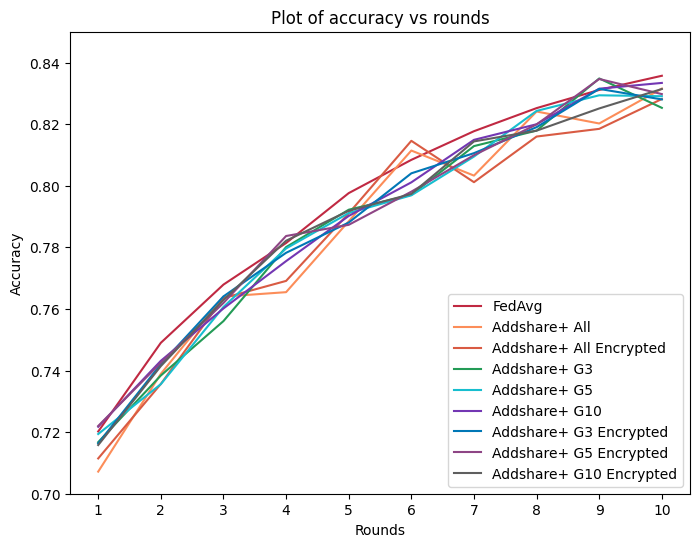

In [6]:
import matplotlib.pyplot as plt
import numpy as np

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Create the plot
plt.figure(figsize=(8, 6))

# Plot the lines with different colors and labels
plt.plot(x, fedavg_acc, label='FedAvg', color='#c02942')
plt.plot(x, addshare_plus_all_acc, label='Addshare+ All', color='#fc8d59')
plt.plot(x, addshare_plus_all_encrypted_acc, label='Addshare+ All Encrypted', color='#d95b43')
plt.plot(x, addshare_plus_server_3_acc, label='Addshare+ G3', color='#239b56')
plt.plot(x, addshare_plus_server_5_acc, label='Addshare+ G5', color='#17becf')
plt.plot(x, addshare_plus_server_10_acc, label='Addshare+ G10', color='#7337b3')
plt.plot(x, addshare_plus_server_encrypted_3_acc, label='Addshare+ G3 Encrypted', color='#0077b6')
plt.plot(x, addshare_plus_server_encrypted_5_acc, label='Addshare+ G5 Encrypted', color='#8e4585')
plt.plot(x, addshare_plus_server_encrypted_10_acc, label='Addshare+ G10 Encrypted', color='#5f5f5f')

# Add labels and title
plt.xlabel('Rounds')
plt.ylabel('Accuracy')
plt.title('Plot of accuracy vs rounds')
plt.ylim(0.7, 0.85)
plt.xticks(np.arange(min(x), max(x) + 1, step=1))

# Add legend
plt.legend()

# Save plot a s a png 
plt.savefig("poster_fmnist_acc.png")

# Show the plot
plt.grid(False)
plt.show()

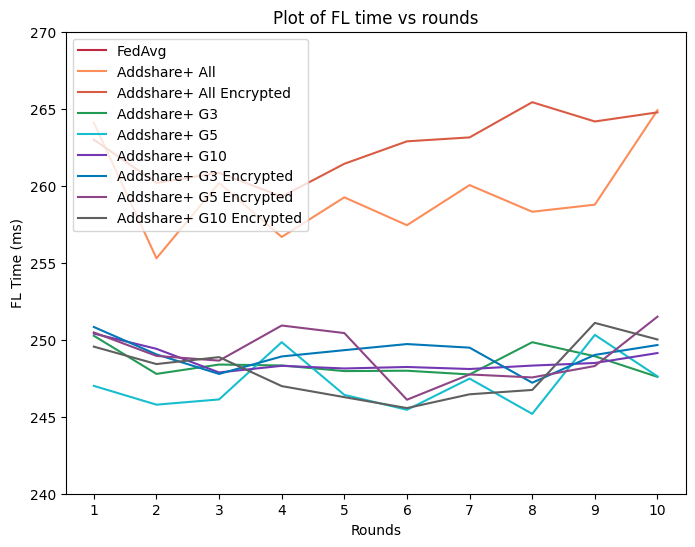

In [7]:
import matplotlib.pyplot as plt
import numpy as np

x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
# Create the plot
plt.figure(figsize=(8, 6))

# Plot the lines with different colors and labels
plt.plot(x, fedavg_time, label='FedAvg', color='#c02942')
plt.plot(x, addshare_plus_all_time, label='Addshare+ All', color='#fc8d59')
plt.plot(x, addshare_plus_all_encrypted_time, label='Addshare+ All Encrypted', color='#d95b43')
plt.plot(x, addshare_plus_server_3_time, label='Addshare+ G3', color='#239b56')
plt.plot(x, addshare_plus_server_5_time, label='Addshare+ G5', color='#17becf')
plt.plot(x, addshare_plus_server_10_time, label='Addshare+ G10', color='#7337b3')
plt.plot(x, addshare_plus_server_encrypted_3_time, label='Addshare+ G3 Encrypted', color='#0077b6')
plt.plot(x, addshare_plus_server_encrypted_5_time, label='Addshare+ G5 Encrypted', color='#8e4585')
plt.plot(x, addshare_plus_server_encrypted_10_time, label='Addshare+ G10 Encrypted', color='#5f5f5f')

# Add labels and title
plt.xlabel('Rounds')
plt.ylabel('FL Time (ms)')
plt.title('Plot of FL time vs rounds')
plt.ylim(240, 270)
plt.xticks(np.arange(min(x), max(x) + 1, step=1))

# Add legend
plt.legend()

# Save plot a s a png 
plt.savefig("poster_fmnist_time.png")

# Show the plot
plt.grid(False)
plt.show()


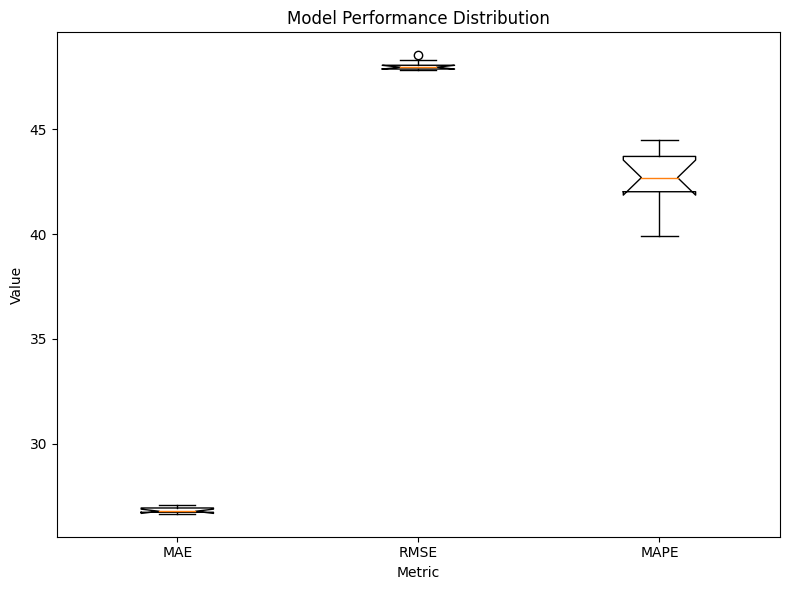

In [7]:
import matplotlib.pyplot as plt

# Sample data (replace with your actual values)
epochs = range(1, 11)  # 10 epochs
mae = [26.72, 26.65, 27.06, 26.92, 26.93, 26.76, 26.69, 26.78, 27.02, 26.73]
rmse = [48.54, 48.31, 47.84, 47.89, 47.88, 47.98, 48.08, 47.96, 47.85, 48.01, ]
mape = [39.92, 40.72, 44.48, 43.65, 43.73, 42.60, 41.91, 42.80, 44.25, 42.37]

plt.figure(figsize=(8, 6))
# Create a figure and subplots

# Box plots
plt.boxplot([mae, rmse, mape], labels=["MAE", "RMSE", "MAPE"], notch=True)
plt.title("Model Performance Distribution")
plt.xlabel("Metric")
plt.ylabel("Value")

# Customize the plot (optional)
plt.tight_layout()

# Save plot a s a png 
plt.savefig("box_plot.png")

# Show the plot
plt.show()


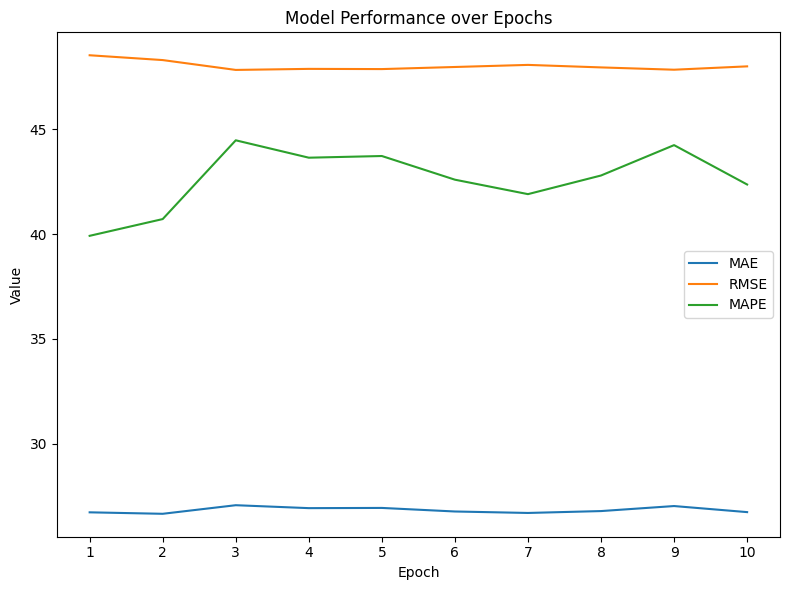

In [13]:
import numpy as np
plt.figure(figsize=(8, 6))

# Line plots (optional)
plt.plot(epochs, mae, label="MAE")
plt.plot(epochs, rmse, label="RMSE")
plt.plot(epochs, mape, label="MAPE")
plt.title("Model Performance over Epochs")
plt.xticks(np.arange(1, 10 + 1, step=1))
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()

# Customize the plot (optional)
plt.tight_layout()

# Save plot as a png 
plt.savefig("line_plot.png")

# Show the plot
plt.show()